# HW 3 - Нейронные сети

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
#!pip install torch torchvision

In [4]:
from tqdm import tqdm
# import warnings
# warnings.simplefilter('ignore')
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
import torch
print(torch.__version__)

1.7.0


# Загрузка данных (5%)

In [5]:
lfw_people = datasets.fetch_lfw_people(
    min_faces_per_person=50, 
    resize=0.4,
)

Выведите:
- кол-во объектов
- Кол-во признаков
- кол-во классов
- посмотрите, сколько изображений соответствет каждому классу

In [6]:
D_out = len(lfw_people.target_names)
D_in = len(lfw_people.data[0])

print("Всего объектов", len(lfw_people.images))
print("Признаков", D_in)
print("Классов", D_out)

print("  где каждому классу соответствует:")
unique, counts = np.unique(lfw_people.target, return_counts=True)
for number in unique:
    print(' ', lfw_people.target_names[number], '-', counts[number])

Всего объектов 1560
Признаков 1850
Классов 12
  где каждому классу соответствует:
  Ariel Sharon - 77
  Colin Powell - 236
  Donald Rumsfeld - 121
  George W Bush - 530
  Gerhard Schroeder - 109
  Hugo Chavez - 71
  Jacques Chirac - 52
  Jean Chretien - 55
  John Ashcroft - 53
  Junichiro Koizumi - 60
  Serena Williams - 52
  Tony Blair - 144


- Отрисуйте изображения для случайных семплов с подписями имен класса 

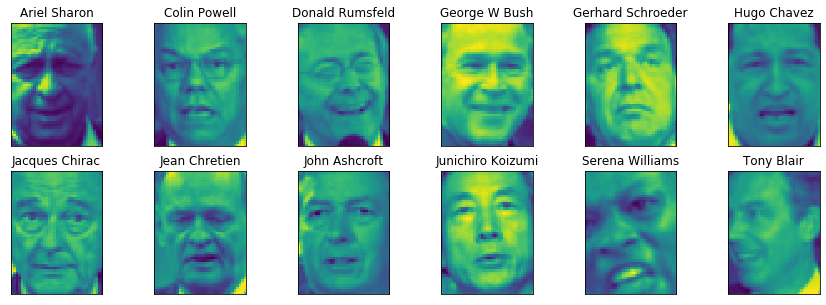

In [7]:
fig = plt.figure(figsize=(15,5))
for i in range(D_out):
    ax = fig.add_subplot(2, 6, 1 + i, xticks=[], yticks=[])
    idx = np.where(lfw_people.target[:]==i)[0]
    img_num = np.random.randint(idx.shape[0])
    img = lfw_people.images[idx[img_num]]
    ax.set_title(lfw_people.target_names[i])
    plt.imshow(img)
plt.show()

#They look better in colour, right?

In [8]:
# Конечно мы сначала должны достать данные и перевести их в тензоры: 
x = torch.from_numpy(lfw_people.images)
y = lfw_people.target

type(x)

torch.Tensor

## Разверните данные в строку, чтобы подать на вход нейросети

In [9]:
x_flat = x.flatten(start_dim=1).float()
print(f'Была размерность: {x.shape}, стала: {x_flat.shape}')

#and if you use "x = torch.from_numpy(lfw_people.data)" x is already flattened

Была размерность: torch.Size([1560, 50, 37]), стала: torch.Size([1560, 1850])


In [10]:
# Разделим данные на трейн/валидацию/тест: 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_flat.numpy(), y, train_size=0.6, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5, random_state = 42)

x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)

In [11]:
print(x_train.shape, x_val.shape, x_test.shape)

torch.Size([936, 1850]) torch.Size([312, 1850]) torch.Size([312, 1850])


# Fully connected neural network (20%)
Создадим нашу первую модель, будем использовать полносвязную нейронную сеть 
- Первый слой: 64 нейрона, функция активации Sigmoid
- Скрытый слой: 32 нейрона, функция активации Sigmoid
- Чтобы наша сеть не переобучалась, после каждого полно-связного используйте слой [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) с параметром p = 0.4
- Выходной слой: на ваше усмотрение :) 
- Функция потерь - ну конечно же ...
- Не забудьте задать инициализацию весов

Будем обучать с помощью Adam на 100 эпохах,  размер сэмпла для минибатча: 10

Тренируемся на train, валидируем на val, тестируемся на test

In [12]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, 64)
        self.dr1 = torch.nn.Dropout(p = 0.4)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(64, 32)
        self.dr2 = torch.nn.Dropout(p = 0.4)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(32, D_out)
        self.act3 = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = self.act1(self.dr1(self.fc1(x)))
        x = self.act2(self.dr2(self.fc2(x)))
        x = self.act3(self.fc3(x))
        return x

model = Model()

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def batch_train(model, loss_fn, learning_rate, x, y):
  # Ваш код здесь
    pred = model(x)
    loss = loss_fn(pred, y)
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate*param.grad
    return(loss.item())

def train(model, n_epochs, batch_size, learning_rate,  X, y, X_test, y_test):
    acc_train_all = []
    loss_train_all = []
    acc_test_all = []
    loss_test_all = []

    for epoch in range(n_epochs):

        permutation = torch.randperm(X.size()[0])

        for i in tqdm(range(0,X.float().size()[0], batch_size)):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], y[indices]
            batch_train(model, loss_fn, learning_rate, batch_x, batch_y)

        y_test_pred = model(X_test)
        y_train_pred = model(X)


        acc_train = accuracy_score(y.numpy(), y_train_pred.argmax(dim=1).numpy())
        loss_train = loss_fn(y_train_pred, y).detach().numpy() 
        acc_test = accuracy_score(y_test.numpy(), y_test_pred.argmax(dim=1).numpy())
        loss_test = loss_fn(y_test_pred, y_test).detach().numpy()

        acc_train_all = np.append(acc_train_all, acc_train)
        loss_train_all = np.append(loss_train_all, loss_train)
        acc_test_all = np.append(acc_test_all, acc_test)
        loss_test_all = np.append(loss_test_all, loss_test)

        #I've muted the output
        #print(f'Epoch {epoch}: \n Accuracy - train: {acc_train} | test: {acc_test} \n Loss - train: {loss_train} | test: {loss_test}')
        
    return(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

def vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all):
    fig = plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)

    plt.plot(loss_train_all, label='loss')
    plt.plot(loss_test_all, label='val_loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_train_all, label='acc')
    plt.plot(acc_test_all, label='val_acc')

    plt.legend()
    plt.show()

Постройте график значения функции потерь на train и val

100%|██████████| 94/94 [00:00<00:00, 380.19it/s]


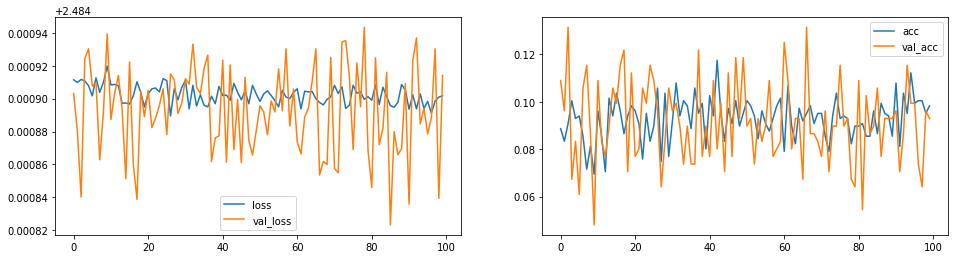

In [16]:
n_epochs = 100
batch_size = 10
learning_rate = 1e-3
model = model.apply(init_weights)

acc_train_all, loss_train_all, acc_test_all, loss_test_all = \
          train(model, n_epochs, batch_size, learning_rate, x_train, y_train, x_val, y_val)

vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

Сколько эпох нужно?

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test)

In [17]:
y_pred = model(x_test)
y_pred = y_pred.argmax(dim=1).numpy()

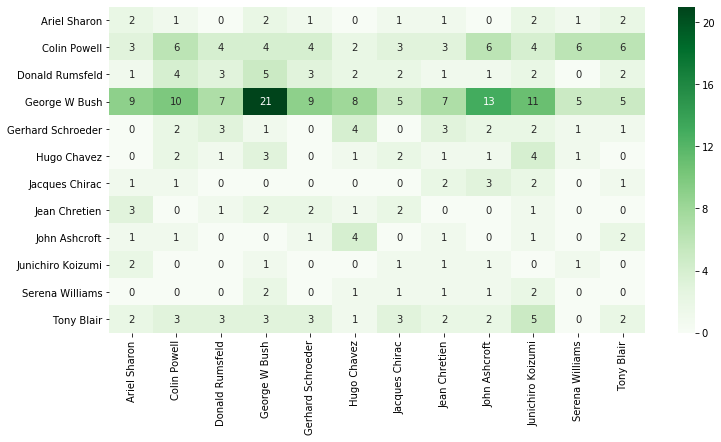

In [18]:
from sklearn.metrics import confusion_matrix

confusionmatrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Посчитайте долю правильных ответов(test)

In [19]:
tp = 0
for i in range(D_out):
    tp += confusionmatrix[i,i]
print(tp/np.sum(confusionmatrix))

0.11217948717948718


Оцените, кого с кем вы чаще всего путаете? Почему одних людей наша сеть путает с другими чаще?

//сетка переобучилась на джорджах бушах и дональдах (т.к. их было много) и всех подряд принимает за них (даже Серену Уильямс:)

Вспомним, что в нашей задачи классы, не сбалансированы, какая получится доля правильных ответов, если мы всегда будем предсказывать константнам значением: George W Bush

In [20]:
confusionmatrix = confusion_matrix(y_test, [3]*np.shape(y_test)[0])
tp = 0
for i in range(D_out):
    tp += confusionmatrix[i,i]
print(tp/np.sum(confusionmatrix))

0.3525641025641026


## А теперь соберите модель посложнее, вам может захотеться (до +10%):
- BatchNorm
- Другую функцию активации
- Нормировать или центрировать данные
- Больше слоев
- Жирнее слои
- Обучаться на GPU (см [семинар 8](https://github.com/ml-dafe/ml_mipt_dafe_major/blob/master/week_08_CNN/Seminar_8_CNN.ipynb))
 - в jupyter notebook Runtime -> Change Runtime type
 - Модель на GPU
 - Данные на GPU


In [21]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def normalize(x, mean, std):
    return (x - mean)/std**(1/2)

mean = x_flat.mean()
std = x_flat.std()

x_train = normalize(x_train, mean, std)
x_val = normalize(x_val, mean, std)
x_test = normalize(x_test, mean, std)

In [22]:
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, 64)
        self.bn1 = torch.nn.BatchNorm1d(64, affine=True)
        self.fc2 = torch.nn.Linear(64, 128)
        self.bn2 = torch.nn.BatchNorm1d(128, affine=True)
        self.fc3 = torch.nn.Linear(128, D_out)
        self.act3 = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.act3(self.fc3(x))
        return x
    
h_model = Model()

100%|██████████| 94/94 [00:00<00:00, 177.80it/s]


100%|██████████| 94/94 [00:00<00:00, 214.52it/s]


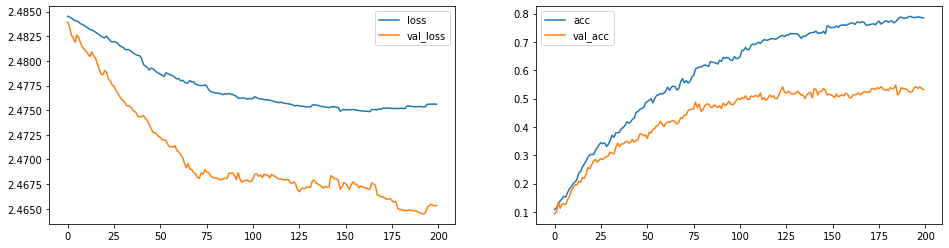

In [23]:
h_model.to(DEVICE)
x_train.to(DEVICE)
y_train.to(DEVICE)

n_epochs = 200
batch_size = 10
learning_rate = 1e-3

h_model = h_model.apply(init_weights)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(h_model.parameters(), lr=learning_rate)

acc_train_all, loss_train_all, acc_test_all, loss_test_all = \
          train(h_model, n_epochs, batch_size, learning_rate, x_train, y_train, x_val, y_val)

vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

# Это же картинки! Попробуем Convolution neural network (30%)
- Используйте два сверточных слоя
 - 16 фильтров (ядер)
 - размер ядра 5 
 - функция активации ReLu
 - padding - 'same' (ну типо чтобы размер картинки не менялся)
- Затем слой MaxPooling'a с размерром 2х2
- Затем полносвязные слои: 32 нейрона и 16 нейронов
- Выходной слой как раньше 
- учить 100 эпох по 64 картинки в батч

In [24]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 5, padding=2)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.fc1 = torch.nn.Linear(16*25*18,32)
        self.fc2 = torch.nn.Linear(32,16)
        self.fc3 = torch.nn.Linear(16, D_out)
        self.act3 = torch.nn.Softmax(dim=0)

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn1(x)
        
        #print(x.shape)
        x = x.view(-1, self.num_flat_features(x))
        #print(x.shape)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.act3(self.fc3(x))
        return x
    
net = CNN()

In [25]:
x_train_img = torch.empty((x_train.shape[0],1, 50, 37))
x_val_img = torch.empty((x_val.shape[0],1, 50, 37))

for i in range(x_train.shape[0]):
    x_train_img[i] = torch.reshape(x_train[i], (1,50,37))
    
for i in range(x_val.shape[0]):
    x_val_img[i] = torch.reshape(x_val[i], (1,50,37))

100%|██████████| 15/15 [00:00<00:00, 24.43it/s]


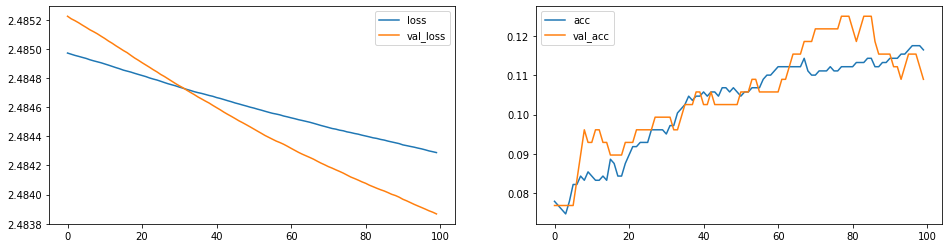

In [26]:
net.to(DEVICE)
x_train_img.to(DEVICE)
y_train.to(DEVICE)

n_epochs = 100
batch_size = 64
learning_rate = 1e-3

net = net.apply(init_weights)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

acc_train_all, loss_train_all, acc_test_all, loss_test_all = \
          train(net, n_epochs, batch_size, learning_rate, x_train_img, y_train, x_val_img, y_val)

vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

Постройте confusion_matrix (используйте sklearn) на тестовой выборке (test) и посчитайте долю правильных ответов(test)

In [27]:
x_test_img = torch.empty((x_test.shape[0],1, 50, 37))

for i in range(x_test.shape[0]):
    x_test_img[i] = torch.reshape(x_test[i], (1,50,37))

y_pred = net(x_test_img)
y_pred = y_pred.argmax(dim=1).numpy()

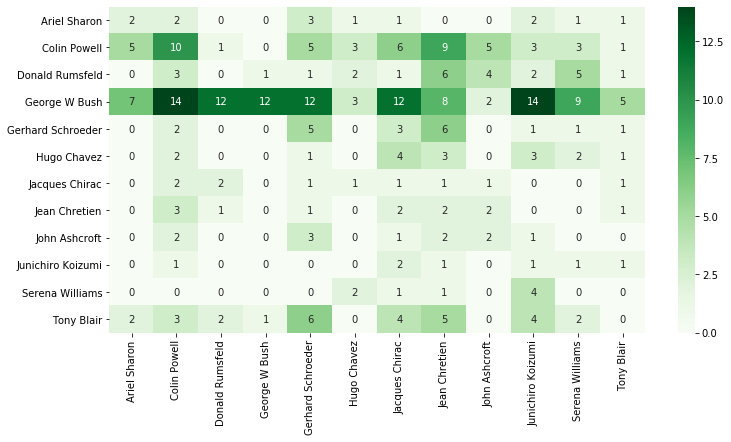

In [28]:
confusionmatrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

Кажется, что стало лучше, но постройте график зависимости доли правильных ответов от эпохи на обучении и валидации. Какие выводы можно сделать?  

//Кажется, все еще происходит переобучение на несбалансированных данных Джорджа Буша

# Aугментация дынных (25%)
Вспомним, что для борьбы с переобучением, нам может помочь Aугментация, для этого мы будем использовать стандартные возможности . Загляните в [доку](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) или в эту [статью](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/) + частично Семинар 8 + Семинар 10

Вы можете использовать любые аугментации

In [29]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import PIL

## Создайте объект transforms

In [105]:
transform = transforms.Compose(
    [
    transforms.RandomAffine(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(37),
    transforms.Normalize(mean=[0.5],
                                std=[0.3])])

Отобразите результат применения Аугментации

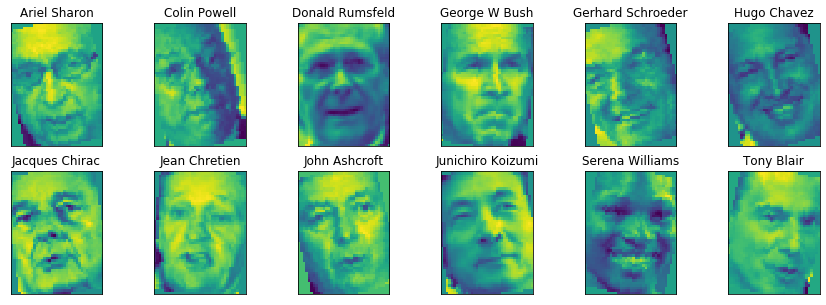

In [106]:
fig = plt.figure(figsize=(15,5))
for i in range(D_out):
    ax = fig.add_subplot(2, 6, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    img_num = np.random.randint(idx.shape[0])
    img = transform(x_train_img[idx[img_num]]).squeeze()
    ax.set_title(lfw_people.target_names[i])
    plt.imshow(img)
plt.show()

## Создайте свой Dataset и DataLoader (доработать приведенную реализацию)

In [107]:
class TrainDataSet(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.transform(self.x[idx]), self.y[idx]

x_train_ds = TrainDataSet(x_train_img, y_train, transform)
x_val_ds = TrainDataSet(x_val_img, y_val, transform)

x_train_dl = torch.utils.data.DataLoader(x_train_ds, 
                                         batch_size=64, 
                                         shuffle=True, 
                                         num_workers=2)
x_val_dl = torch.utils.data.DataLoader(x_val_ds, 
                                         batch_size=64, 
                                         shuffle=True, 
                                         num_workers=2)


In [33]:
def train_cnn(net, n_epochs, learning_rate, x_train_dl, y_train, x_test, y_test):
    acc_train_all = []
    loss_train_all = []
    acc_test_all = []
    loss_test_all = []

    for i, epoch in enumerate(range(n_epochs)):

        for inputs, labels in x_train_dl:
        
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            y_test_pred = net(transform(x_test_img))
            y_train_pred = net(transform(x_train_img))
            
            #print("y_train", y_train.shape, "y_train_pred", y_train_pred.detach().numpy().shape)
            
            acc_train = accuracy_score(y_train.numpy(), y_train_pred.argmax(dim=1).numpy())
            loss_train = loss_fn(y_train_pred, y_train).detach().numpy() 
            acc_test = accuracy_score(y_test.numpy(), y_test_pred.argmax(dim=1).numpy())
            loss_test = loss_fn(y_test_pred, y_test).detach().numpy()

            acc_train_all = np.append(acc_train_all, acc_train)
            loss_train_all = np.append(loss_train_all, loss_train)
            acc_test_all = np.append(acc_test_all, acc_test)
            loss_test_all = np.append(loss_test_all, loss_test)
            
        print(f'Epoch {epoch}: \n Accuracy - train: {acc_train:.2f} | test: {acc_test:.2f} \n Loss - train: {loss_train:.2f} | test: {loss_test:.2f}')
        
    return(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

## Обучите нейросеть с применением аугментаций

In [34]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 5, padding=2)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.fc1 = torch.nn.Linear(16*18*18,32)
        self.fc2 = torch.nn.Linear(32,16)
        self.fc3 = torch.nn.Linear(16, D_out)
        self.act3 = torch.nn.Softmax(dim=0)

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.bn1(x)
        
        x = x.view(-1, self.num_flat_features(x))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.act3(self.fc3(x))
        return x
    
net = CNN()

In [35]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Epoch 0: 
 Accuracy - train: 0.10 | test: 0.09 
 Loss - train: 2.48 | test: 2.48
Epoch 1: 
 Accuracy - train: 0.09 | test: 0.07 
 Loss - train: 2.48 | test: 2.48
Epoch 2: 
 Accuracy - train: 0.11 | test: 0.08 
 Loss - train: 2.48 | test: 2.48
Epoch 3: 
 Accuracy - train: 0.12 | test: 0.06 
 Loss - train: 2.48 | test: 2.48
Epoch 4: 
 Accuracy - train: 0.08 | test: 0.09 
 Loss - train: 2.48 | test: 2.48
Epoch 5: 
 Accuracy - train: 0.11 | test: 0.04 
 Loss - train: 2.48 | test: 2.49
Epoch 6: 
 Accuracy - train: 0.10 | test: 0.04 
 Loss - train: 2.48 | test: 2.49
Epoch 7: 
 Accuracy - train: 0.11 | test: 0.07 
 Loss - train: 2.48 | test: 2.49
Epoch 8: 
 Accuracy - train: 0.09 | test: 0.05 
 Loss - train: 2.48 | test: 2.48
Epoch 9: 
 Accuracy - train: 0.12 | test: 0.06 
 Loss - train: 2.48 | test: 2.48
Epoch 10: 
 Accuracy - train: 0.09 | test: 0.04 
 Loss - train: 2.48 | test: 2.49
Epoch 11: 
 Accuracy - train: 0.11 | test: 0.06 
 Loss - train: 2.48 | test: 2.48
Epoch 12: 
 Accuracy - tra

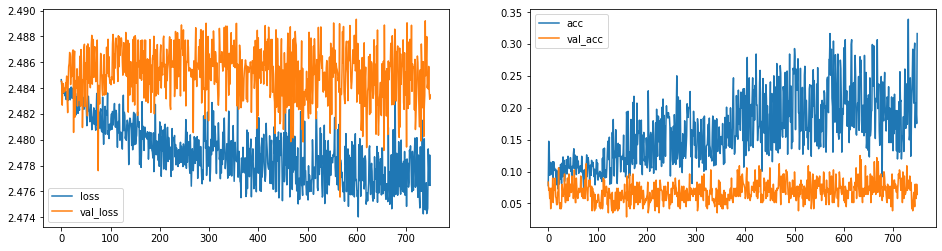

In [36]:
net.to(DEVICE)
x_train_img.to(DEVICE)
y_train.to(DEVICE)

n_epochs = 50
batch_size = 64
learning_rate = 1e-3

net = net.apply(init_weights)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

acc_train_all, loss_train_all, acc_test_all, loss_test_all = \
        train_cnn(net, n_epochs, learning_rate, x_train_dl, y_train, x_val_img, y_val)

vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

Посмотрите долю правильных ответов на тестовой выборке и постройте график зависимости от эпох для обучения и валидации
Ответьте на вопросы и объясните свой ответ: 
- Удалось ли Вам победить переобучение? 
- Будет ли полезна аугментация RandomHorizontalFlip? а RandomVerticalFlip?

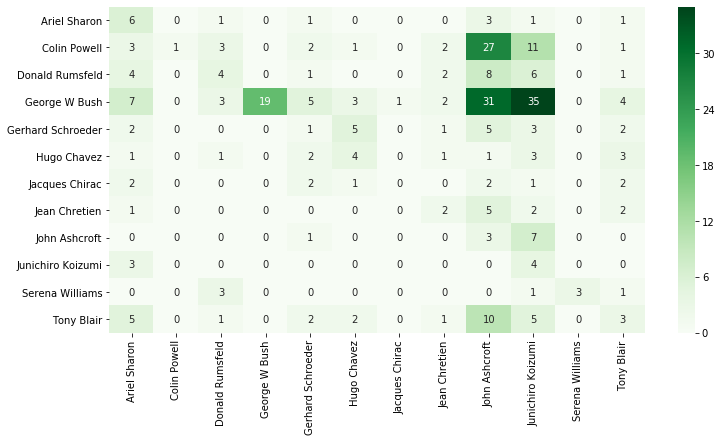

True positive = 0.16025641025641027


In [37]:
y_pred = net(transform(x_test_img))
y_pred = y_pred.argmax(dim=1).numpy()

confusionmatrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)
plt.show()

tp = 0
for i in range(D_out):
    tp += confusionmatrix[i,i]
    
print("True positive =", tp/np.sum(confusionmatrix))

стало намноооооого лучше

становилось, но в какой-то момент перестало
А флипы любого вида только собьют с толку модели, ведь лицо - ориентированный объект

# А теперь попробуем предобученные нейросети (конечно же сверточные) (20%)
Подробнее в [документации](https://pytorch.org/docs/stable/torchvision/models.html) 
- Попробуйте оживить Inception
- Если не получится, то хотябы ResNet



In [38]:
import torchvision.models as models
inception = models.inception_v3(pretrained=True)

fc_12 = torch.nn.Sequential(torch.nn.Linear(2048, 12))
inception.fc = fc_12

In [39]:
import cv2

x_train_resized = torch.empty((x_train.shape[0], 3, 299, 299))

for i in range(x_train_img.shape[0]):
    tmp = cv2.resize(np.double(x_train_img[i].squeeze()), (299,299))
    tmp = tmp * 3
    tmp = np.resize(img, (3,299,299))
    x_train_resized[i] = torch.from_numpy(tmp)
    x_train_resized[i] = (x_train_resized[i]).float()
    
x_val_resized = torch.empty((x_val.shape[0], 3, 299, 299))

for i in range(x_val_img.shape[0]):
    tmp = cv2.resize(np.double(x_val_img[i].squeeze()), (299,299))
    tmp = tmp * 3
    tmp = np.resize(img, (3,299,299))
    x_val_resized[i] = torch.from_numpy(tmp)
    x_val_resized[i] = (x_val_resized[i]).float()

In [40]:
inception.to(DEVICE)
x_train_img.to(DEVICE)
y_train.to(DEVICE)

n_epochs = 50
batch_size = 64
learning_rate = 1e-3

inception = inception.apply(init_weights)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

acc_train_all, loss_train_all, acc_test_all, loss_test_all = \
        train(inception, n_epochs, batch_size, learning_rate, x_train_resized, y_train, x_val_resized, y_val)

vis_history(acc_train_all, loss_train_all, acc_test_all, loss_test_all)

  0%|          | 0/15 [00:00<?, ?it/s]


KeyboardInterrupt: 

Я прикрутила этот inception, но мой комп давится этой клеткой и вылетает

Возможно, я что-то сделала не так, но я думаю, он просто не тянет

## Дополнительное задание (дополнительные +15%) 
Обучите такую нейронную сеть, чтобы на тестовой выборке достичь доли правильных ответов больше 92%

In [45]:
!pip install googlenet_pytorch

In [103]:
def train(n_epochs, train_loader, val_loader):
    for epoch in range(n_epochs):
        #training on the train part
        model.train()
        cur_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader): 
            data, target = Variable(data), Variable(target)
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()

            blank = np.zeros_like(data.squeeze())
            data_expanded = torch.from_numpy(np.stack((data.squeeze(), blank, blank), axis=1))
            
            optimizer.zero_grad()
            output  = model(data_expanded)
            loss = criterion(output.logits, target)
            loss.backward()
            optimizer.step()
            cur_loss += loss.item()

        print('Epoch #{}:\n train loss = {:.4f}'.format(epoch, loss.item()))
        train_loss.append(cur_loss / len(train_loader))
        #validating
        model.eval()
        cur_loss = 0

        for data, target in val_loader:
            data, target = Variable(data), Variable(target)
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()
            
            blank = np.zeros_like(data.squeeze())
            data_expanded = torch.from_numpy(np.stack((data.squeeze(), blank, blank), axis=1))
            
            output  = model(data_expanded)
            cur_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            
        cur_loss /= len(val_loader.dataset)
        valid_loss.append(cur_loss)
        print(' val loss = {:.4f}\n'.format(cur_loss))
        
    return train_loss, valid_loss

In [136]:
transform = transforms.Compose(
    [
    transforms.RandomAffine(20),
    transforms.Normalize(mean=[0.5],
                                std=[0.3])
    ])
x_train_ds = TrainDataSet(x_train_img, y_train, transform)
x_val_ds = TrainDataSet(x_val_img, y_val, transform)
x_train_dl = torch.utils.data.DataLoader(x_train_ds, batch_size=64, shuffle=True, num_workers=2)
x_val_dl = torch.utils.data.DataLoader(x_val_ds, batch_size=64, shuffle=True, num_workers=2)

In [137]:
from googlenet_pytorch import GoogLeNet
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

model = GoogLeNet.from_pretrained('googlenet')
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

train_loss = []
valid_loss = []
n_epochs = 30

train_loss, val_loss = train(n_epochs, x_train_dl, x_val_dl)

Loaded pretrained weights for googlenet
Epoch #0:
 train loss = 1.6653
 val loss = 3.2575

Epoch #1:
 train loss = 0.8710
 val loss = 1.5841

Epoch #2:
 train loss = 0.7374
 val loss = 1.2570

Epoch #3:
 train loss = 0.4121
 val loss = 0.9676

Epoch #4:
 train loss = 0.4888
 val loss = 0.8464

Epoch #5:
 train loss = 0.2673
 val loss = 0.8275

Epoch #6:
 train loss = 0.2441
 val loss = 0.7481

Epoch #7:
 train loss = 0.2972
 val loss = 0.9030

Epoch #8:
 train loss = 0.0801
 val loss = 0.8835

Epoch #9:
 train loss = 0.0684
 val loss = 0.7753

Epoch #10:
 train loss = 0.1086
 val loss = 0.8441

Epoch #11:
 train loss = 0.1224
 val loss = 0.7877

Epoch #12:
 train loss = 0.2367
 val loss = 0.6417

Epoch #13:
 train loss = 0.0237
 val loss = 0.6787

Epoch #14:
 train loss = 0.2206
 val loss = 0.6181

Epoch #15:
 train loss = 0.5138
 val loss = 0.7075

Epoch #16:
 train loss = 0.0978
 val loss = 0.5847

Epoch #17:
 train loss = 0.2480
 val loss = 0.6907

Epoch #18:
 train loss = 0.0138
 v

In [138]:
def vis_history(loss_train_all, loss_test_all):
    fig = plt.figure(figsize=(16, 4))

    plt.plot(loss_train_all, label='loss')
    plt.plot(loss_test_all, label='val_loss')

    plt.grid()
    plt.legend()
    plt.show()

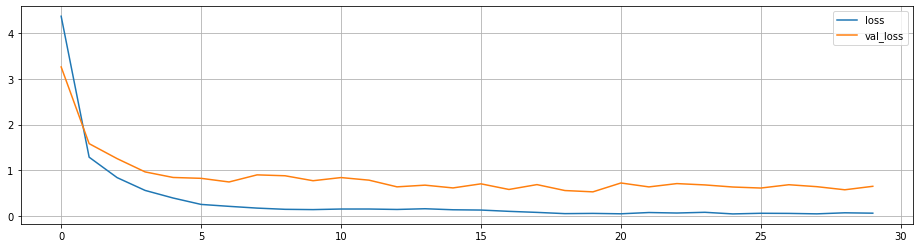

In [139]:
vis_history(train_loss, val_loss)

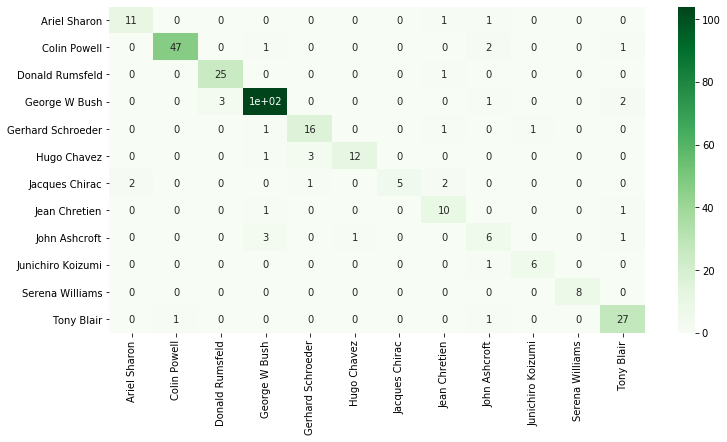

In [140]:
blank = np.zeros_like(x_test_img.squeeze())
data_expanded = torch.from_numpy(np.stack((x_test_img.squeeze(), blank, blank), axis=1))

y_pred = model(transform(data_expanded))
y_pred = y_pred.argmax(dim=1).numpy()

confusionmatrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(confusionmatrix, cmap='Greens', annot=True,
            xticklabels=lfw_people.target_names,
            yticklabels=lfw_people.target_names)

In [141]:
from sklearn.metrics import accuracy_score
print("Accuracy =", accuracy_score(y_test, y_pred))

Accuracy = 0.8878205128205128


Я пыталась :(